In [1]:
import arviz as az
import bambi as bmb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from bambi.plots import plot_cap

## Gaussian Linear Model

For the first demonstration, we will use a Gaussian linear regression model to better understand the `plot_cap` function and its arguments. 

In [113]:
# Load data
data = bmb.load_data('mtcars')
data["cyl"] = data["cyl"].replace({4: "low", 6: "medium", 8: "high"})
data["gear"] = data["gear"].replace({3: "A", 4: "B", 5: "C"})
data["cyl"] = pd.Categorical(data["cyl"], categories=["low", "medium", "high"], ordered=True)

# Define and fit the Bambi model
model = bmb.Model("mpg ~ hp * wt", data)
idata = model.fit(draws=1000, target_accept=0.95, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mpg_sigma, Intercept, hp, wt, hp:wt]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [114]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,49.012,3.704,42.000,55.929,0.109,0.077,1164.0,1578.0,1.00
hp,-0.114,0.025,-0.161,-0.065,0.001,0.001,1207.0,1451.0,1.01
wt,-7.951,1.306,-10.298,-5.319,0.037,0.026,1232.0,1696.0,1.00
hp:wt,0.026,0.008,0.012,0.041,0.000,0.000,1139.0,1427.0,1.00
mpg_sigma,2.242,0.307,1.681,2.805,0.007,0.005,1760.0,2081.0,1.00


In [146]:
# original
preds = model.predict(idata, kind="mean", inplace=False)
mean_preds = preds.posterior.mpg_mean.mean(("chain", "draw"))
mean_std = preds.posterior.mpg_mean.std(("chain", "draw"))

In [116]:
new_grid = {
    'hp': data.hp + 10, 
    'wt': data.wt
    }
new_grid = pd.DataFrame.from_dict(new_grid)

In [117]:
preds_new = model.predict(
    idata,
    "mean",
    new_grid,
    inplace=False
)

In [147]:
mean_preds_new = preds_new.posterior.mpg_mean.mean(("chain", "draw"))
mean_std_new = preds_new.posterior.mpg_mean.std(("chain", "draw"))

In [163]:
diff = mean_preds_new - mean_preds
std = np.std(diff) 

In [164]:
diff

<xarray.DataArray 'mpg_mean' (mpg_obs: 32)>
array([-0.45981972, -0.3932016 , -0.53819398, -0.30437743, -0.24559674,
       -0.24037179, -0.21163456, -0.31090862, -0.32135852, -0.24559674,
       -0.24559674, -0.08101079, -0.16983495, -0.15677258,  0.2272613 ,
        0.27271837,  0.25207982, -0.56954368, -0.72237349, -0.66489903,
       -0.50031308, -0.22469694, -0.24690298, -0.14109772, -0.13979149,
       -0.63877428, -0.58521853, -0.74902074, -0.31613357, -0.42063259,
       -0.21163456, -0.41802011])
Coordinates:
  * mpg_obs  (mpg_obs) int64 0 1 2 3 4 5 6 7 8 9 ... 23 24 25 26 27 28 29 30 31

In [166]:
data['wt_sorted'] = data['wt'].sort_values().reset_index(drop=True)

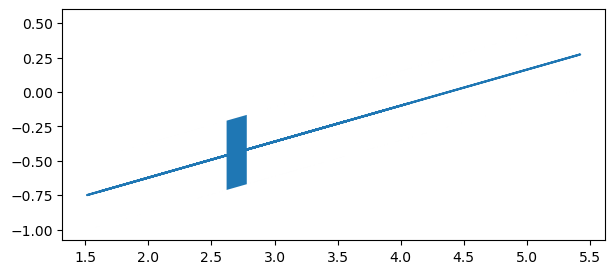

In [168]:
plt.figure(figsize=(7, 3))
plt.plot(data['wt'].astype(float), diff);
plt.fill_between(
    x=data['wt'].astype(float),
    y1=diff + std,
    y2=diff - std
);

In [95]:
titanic_path = "https://vincentarelbundock.github.io/Rdatasets/csv/Stat2Data/Titanic.csv"
titanic_df = pd.read_csv(titanic_path).drop(columns="Unnamed: 0")

TypeError: repl must be a string or callable

In [93]:
titanic_df

,Name,PClass,Age,Sex,Survived,SexCode
0,"Allen, Miss Elisabeth Walton",1st,29.00,female,1,1
1,"Allison, Miss Helen Loraine",1st,2.00,female,0,1
2,"Allison, Mr Hudson Joshua Creighton",1st,30.00,male,0,0
3,"Allison, Mrs Hudson JC (Bessie Waldo Daniels)",1st,25.00,female,0,1
4,"Allison, Master Hudson Trevor",1st,0.92,male,1,0
...,...,...,...,...,...,...
1308,"Zakarian, Mr Artun",3rd,27.00,male,0,0
1309,"Zakarian, Mr Maprieder",3rd,26.00,male,0,0
1310,"Zenni, Mr Philip",3rd,22.00,male,0,0
1311,"Lievens, Mr Rene",3rd,24.00,male,0,0
